In [1]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import itertools
import time
movies = pd.read_csv('movie_industry_clean.csv')

In [2]:
# data wrangling
def wrangling(df):
    df = df.drop('Unnamed: 0', axis=1)
    df.replace(' ', '_', regex=True, inplace = True)
    df.replace('-', '_', regex=True, inplace = True)
    return df

movies = wrangling(movies)

In [3]:
# grouping countries into continents
def continent(s):
    if s['country'] in ['United_States','Mexico', 'Canada','Jamaica']:
        return 'North_America'
    if s['country'] in ['United_Kingdom', 'France', 'Germany', 'Belgium','Spain', 'Norway', 'Iceland', 'West_Germany', 'Ireland', 'Italy', 'Finland', 'Czech_Republic', 'Switzerland', 'Sweden', 'Denmark', 'Netherlands','Federal_Republic_of_Yugoslavia','Yugoslavia', 'Hungary', 'Republic_of_Macedonia', 'Austria','Portugal','Malta']:
        return 'Europe'
    if s['country'] in ['Japan','China','South_Korea', 'Hong_Kong','India','United_Arab_Emirates','Taiwan','Lebanon','Indonesia', 'Iran','Israel','Russia','Thailand']:
        return 'Asia'
    if s['country'] in ['Australia','New_Zealand']:
        return 'Oceania'
    if s['country'] in ['South_Africa', 'Kenya']:
        return 'Africa'
    if s['country'] in ['Brazil', 'Argentina', 'Aruba', 'Chile', 'Panama','Colombia']:
        return 'South_America'
    else:
        return 'NA'

movies['continent'] = movies.apply(continent, axis=1)

In [6]:
movies.rating.value_counts()

R            2597
PG_13        1729
PG            907
G             111
Not_Rated      44
Unrated        17
NC_17          12
TV_MA           2
Approved        1
X               1
Name: rating, dtype: int64

In [55]:
summary_stats = movies.gross.describe()

summary_df = pd.DataFrame(summary_stats)

summary_df

,gross
count,5.415000e+03
mean,1.033429e+08
std,1.873755e+08
min,3.090000e+02
25%,1.077476e+07
50%,3.712171e+07
75%,1.127340e+08
max,2.847246e+09


In [56]:
# split into training & test
np.random.seed(2)
train = movies.sample(round(movies.shape[0]*0.8)) # 80%
test = movies.drop(train.index)

In [58]:
train_countries = pd.Series(train.country.unique())
test_countries = pd.Series(test.country.unique())

intersection = set(train_countries)&set(test_countries)
intersection

train['countries'] = train.loc[:, 'country']
test['countries'] = test.loc[:, 'country']

train.loc[~train.country.isin(intersection), "countries" ] = 'other'
test.loc[~test.country.isin(intersection), "countries" ] = 'other'

## INITIAL EDA (incomplete, can be built off of)

### MODEL WITHOUT TRANFORMATIONS

In [59]:
# the start of a model by hand - NO INTERACTIONS/TRANSFORMATIONS
ols_object = smf.ols(formula = 'gross~budget+genre+rating+votes+continent+runtime+score+year+month', data = train)
model = ols_object.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  gross   R-squared:                       0.679
Model:                            OLS   Adj. R-squared:                  0.675
Method:                 Least Squares   F-statistic:                     205.9
Date:                Sun, 12 Mar 2023   Prob (F-statistic):               0.00
Time:                        04:04:13   Log-Likelihood:                -86175.
No. Observations:                4332   AIC:                         1.724e+05
Df Residuals:                    4287   BIC:                         1.727e+05
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                  -6.371e+08   3.66e+08     -1.742      0.082   -1.35e+09    8.01e+07
genre[T.Adventure]          7.329e+06   7.75e+06      0.945      0.345   -7.87e+06    2.25e+07
genre[T.Animation]          6.555e+07   1.01e+07      6.475      0.000    4.57e+07    8.54e+07
genre[T.Biography]         -8.044e+06   8.13e+06     -0.989      0.323    -2.4e+07     7.9e+06
genre[T.Comedy]             1.422e+07   4.75e+06      2.991      0.003     4.9e+06    2.35e+07
genre[T.Crime]             -1.072e+06    7.1e+06     -0.151      0.880    -1.5e+07    1.28e+07
genre[T.Drama]              3.257e+06   5.65e+06      0.576      0.564   -7.82e+06    1.43e+07
genre[T.Family]              4.78e+08   6.15e+07      7.768      0.000    3.57e+08    5.99e+08
genre[T.Fantasy]            2.206e+07   2.01e+07      1.099      0.272   -1.73e+07    6.14e+07
genre[T.Horror]             4.247e+07   8.46e+06      5.021      0.000    2.59e+07    5.91e+07
genre[T.Mystery]            1.047e+07   3.09e+07      0.339      0.735   -5.01e+07     7.1e+07
genre[T.Romance]           -3.828e+06   5.33e+07     -0.072      0.943   -1.08e+08    1.01e+08
genre[T.Sci_Fi]            -1.788e+07   4.35e+07     -0.411      0.681   -1.03e+08    6.74e+07
genre[T.Thriller]           4.746e+07   4.76e+07      0.996      0.319    -4.6e+07    1.41e+08
genre[T.Western]            4.557e+06   1.06e+08      0.043      0.966   -2.04e+08    2.13e+08
rating[T.G]                -6.238e+07   1.07e+08     -0.581      0.561   -2.73e+08    1.48e+08
rating[T.NC_17]            -6.108e+07   1.12e+08     -0.546      0.585    -2.8e+08    1.58e+08
rating[T.Not_Rated]        -4.883e+07   1.08e+08     -0.451      0.652   -2.61e+08    1.63e+08
rating[T.PG]               -4.585e+07   1.07e+08     -0.430      0.667   -2.55e+08    1.63e+08
rating[T.PG_13]            -5.642e+07   1.07e+08     -0.529      0.597   -2.66e+08    1.53e+08
rating[T.R]                -7.041e+07   1.07e+08     -0.660      0.509    -2.8e+08    1.39e+08
rating[T.TV_MA]            -6.344e+07   1.51e+08     -0.421      0.674   -3.59e+08    2.32e+08
rating[T.Unrated]          -4.194e+07   1.11e+08     -0.376      0.707    -2.6e+08    1.77e+08
rating[T.X]                -1.022e+08   1.51e+08     -0.678      0.498   -3.98e+08    1.94e+08
continent[T.Asia]            2.55e+07   6.25e+07      0.408      0.683   -9.69e+07    1.48e+08
continent[T.Europe]         3.346e+06   6.15e+07      0.054      0.957   -1.17e+08    1.24e+08
continent[T.NA]               -0.0006      0.003     -0.181      0.857      -0.007       0.005
continent[T.North_America]  1.821e+07   6.14e+07      0.297      0.767   -1.02e+08    1.39e+08
continent[T.Oceania]        2.615e+07   6.31e+07      0.414      0.679   -9.76e+07     1.5e+08
continent[T.South_America]  1.252e+07   7.5

### TAKEAWAYS
- runtime & year do not seem to be significant
- only some of the genres seems to be significant - more evidence that they are signficant in backwards stepwise selection
- rating does not seem to be signficant
- some months are significant 

### LINEARITY ASSUMPTIONS (with model with no interactions/transformations)

Text(0, 0.5, 'Residuals')

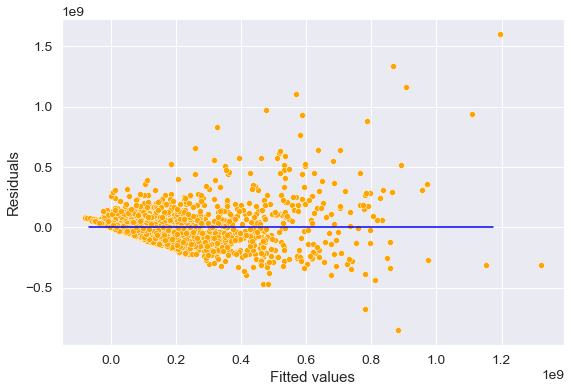

In [60]:
#Plotting residuals vs fitted values
pred_gross = model.predict(test)
plt.rcParams["figure.figsize"] = (9,6)
sns.set(font_scale=1.25)
ax = sns.scatterplot(x = model.fittedvalues, y=model.resid,color = 'orange')
sns.lineplot(x = [pred_gross.min(),pred_gross.max()],y = [0,0],color = 'blue')
plt.xlabel('Fitted values')
plt.ylabel('Residuals')

### MODEL WITH TRANSFORMATIONS/INTERACTIONS

In [61]:
# the start of a model by hand
ols_object = smf.ols(formula = 'gross~budget*genre*month+score*votes+rating+I(budget**2)+I(votes**2)+I(score*votes**2)', data = train)
model = ols_object.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  gross   R-squared:                       0.762
Model:                            OLS   Adj. R-squared:                  0.754
Method:                 Least Squares   F-statistic:                     98.51
Date:                Sun, 12 Mar 2023   Prob (F-statistic):               0.00
Time:                        04:04:15   Log-Likelihood:                -85530.
No. Observations:                4332   AIC:                         1.713e+05
Df Residuals:                    4195   BIC:                         1.722e+05
Df Model:                         136                                         
Covariance Type:            nonrobust                                         
================================================================================================================
                                                   coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------
Intercept                                        0.0174      0.001     13.054      0.000       0.015       0.020
genre[T.Adventure]                              -0.0095      0.001    -13.057      0.000      -0.011      -0.008
genre[T.Animation]                              -0.0005   3.81e-05    -13.029      0.000      -0.001      -0.000
genre[T.Biography]                               0.0006    4.3e-05     13.056      0.000       0.000       0.001
genre[T.Comedy]                                  0.0051      0.000     13.049      0.000       0.004       0.006
genre[T.Crime]                                   0.0008   6.14e-05     13.055      0.000       0.001       0.001
genre[T.Drama]                                   0.0031      0.000     13.055      0.000       0.003       0.004
genre[T.Family]                               2.979e-06   4.93e-07      6.045      0.000    2.01e-06    3.95e-06
genre[T.Fantasy]                                 0.0001   1.08e-05      9.590      0.000    8.27e-05       0.000
genre[T.Horror]                                  0.0038      0.000     13.043      0.000       0.003       0.004
genre[T.Mystery]                             -1.965e-05   2.07e-06     -9.490      0.000   -2.37e-05   -1.56e-05
genre[T.Romance]                              2.492e-08   4.75e-07      0.052      0.958   -9.07e-07    9.57e-07
genre[T.Sci_Fi]                               9.449e-06   2.63e-06      3.591      0.000    4.29e-06    1.46e-05
genre[T.Thriller]                            -7.473e-06   3.57e-06     -2.093      0.036   -1.45e-05   -4.74e-07
genre[T.Western]                             -1.125e-08   3.82e-07     -0.029      0.976   -7.59e-07    7.37e-07
month[T.August]                                  0.0020      0.000     13.050      0.000       0.002       0.002
month[T.December]                                0.0002   1.27e-05     13.158      0.000       0.000       0.000
month[T.February]                                0.0009   7.08e-05     13.046      0.000       0.001       0.001
month[T.January]                                 0.0022      0.000     13.054      0.000       0.002       0.003
month[T.July]                                    0.0019      0.000     13.054      0.000       0.002       0.002
month[T.June]                                    0.0008   5.84e-05     13.138      0.000       0.001       0.001
month[T.March]                                   0.0011   8.32e-05     13.053      0.000       0.001       0.001
month[T.May]                                     0.0005    4.1e-05     12.847      0.000       0.000       0.001
month[T.November]                                0.0013   9.71e-05     13.055      0.000       0.001       0.001
month[T.October]                

In [78]:
# sqrt of the mode
ols_object = smf.ols(formula = 'np.sqrt(gross)~budget*genre*month+score*votes+rating+I(budget**2)+I(votes**2)+I(score*votes**2)', data = train)
model_sqrt = ols_object.fit()
model_sqrt.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         np.sqrt(gross)   R-squared:                       0.762
Model:                            OLS   Adj. R-squared:                  0.754
Method:                 Least Squares   F-statistic:                     98.67
Date:                Sun, 12 Mar 2023   Prob (F-statistic):               0.00
Time:                        04:04:59   Log-Likelihood:                -41040.
No. Observations:                4332   AIC:                         8.235e+04
Df Residuals:                    4195   BIC:                         8.323e+04
Df Model:                         136                                         
Covariance Type:            nonrobust                                         
================================================================================================================
                                                   coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------
Intercept                                     1.313e-06   4.62e-08     28.408      0.000    1.22e-06     1.4e-06
genre[T.Adventure]                           -7.159e-07   2.52e-08    -28.402      0.000   -7.65e-07   -6.66e-07
genre[T.Animation]                            -3.74e-08   1.32e-09    -28.332      0.000      -4e-08   -3.48e-08
genre[T.Biography]                            4.239e-08   1.49e-09     28.427      0.000    3.95e-08    4.53e-08
genre[T.Comedy]                               3.822e-07   1.35e-08     28.392      0.000    3.56e-07    4.09e-07
genre[T.Crime]                                 6.05e-08   2.13e-09     28.418      0.000    5.63e-08    6.47e-08
genre[T.Drama]                                2.305e-07   8.11e-09     28.413      0.000    2.15e-07    2.46e-07
genre[T.Family]                               8.592e-11   1.71e-11      5.030      0.000    5.24e-11    1.19e-10
genre[T.Fantasy]                              8.068e-09   3.76e-10     21.476      0.000    7.33e-09     8.8e-09
genre[T.Horror]                               2.896e-07   1.02e-08     28.371      0.000     2.7e-07     3.1e-07
genre[T.Mystery]                             -1.486e-09   7.18e-11    -20.704      0.000   -1.63e-09   -1.34e-09
genre[T.Romance]                              4.478e-12   1.65e-11      0.272      0.786   -2.78e-11    3.68e-11
genre[T.Sci_Fi]                                7.38e-10   9.12e-11      8.092      0.000    5.59e-10    9.17e-10
genre[T.Thriller]                            -4.496e-10   1.24e-10     -3.634      0.000   -6.92e-10   -2.07e-10
genre[T.Western]                              7.758e-13   1.32e-11      0.059      0.953   -2.52e-11    2.67e-11
month[T.August]                                1.47e-07   5.18e-09     28.388      0.000    1.37e-07    1.57e-07
month[T.December]                             1.258e-08   4.38e-10     28.684      0.000    1.17e-08    1.34e-08
month[T.February]                             6.974e-08   2.45e-09     28.441      0.000    6.49e-08    7.45e-08
month[T.January]                              1.678e-07    5.9e-09     28.418      0.000    1.56e-07    1.79e-07
month[T.July]                                 1.437e-07   5.06e-09     28.395      0.000    1.34e-07    1.54e-07
month[T.June]                                 5.769e-08   2.02e-09     28.497      0.000    5.37e-08    6.17e-08
month[T.March]                                8.183e-08   2.88e-09     28.389      0.000    7.62e-08    8.75e-08
month[T.May]                                  3.983e-08   1.42e-09     28.037      0.000     3.7e-08    4.26e-08
month[T.November]                             9.552e-08   3.36e-09     28.397      0.000    8.89e-08    1.02e-07
month[T.October]                

In [79]:
# RSE on training data
print(np.sqrt(model_sqrt.mse_resid))
# RMSE
pred_sqrt_gross = model_sqrt.predict(test)
print(np.sqrt(((np.sqrt(test.gross) - pred_sqrt_gross)**2).mean()))

3199.9640062355315
3560.735478371004


#### The model without the np.sqrt(gross) (just 'gross') seems to be better for prediction, but the one with the np.sqrt(gross) seems to be better for inference.

### LINEARITY ASSUMPTIONS (with model with interactions/transformations)

Text(0, 0.5, 'Residuals')

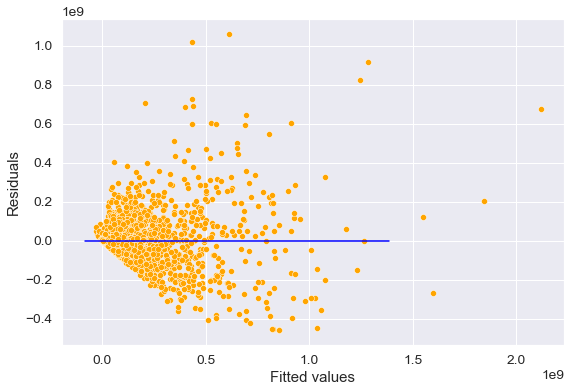

In [80]:
#Plotting residuals vs fitted values
pred_gross = model.predict(test)
plt.rcParams["figure.figsize"] = (9,6)
sns.set(font_scale=1.25)
ax = sns.scatterplot(x = model.fittedvalues, y=model.resid,color = 'orange')
sns.lineplot(x = [pred_gross.min(),pred_gross.max()],y = [0,0],color = 'blue')
plt.xlabel('Fitted values')
plt.ylabel('Residuals')

Text(0, 0.5, 'Residuals')

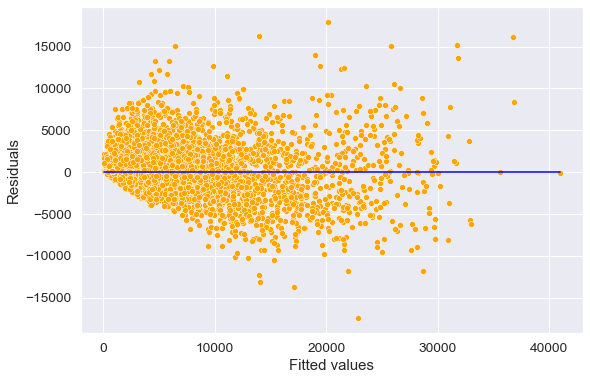

In [81]:
# log model
sns.scatterplot(x = (model_sqrt.fittedvalues), y=(model_sqrt.resid),color = 'orange')
sns.lineplot(x = [model_sqrt.fittedvalues.min(),model_sqrt.fittedvalues.max()],y = [0,0],color = 'blue')
plt.xlabel('Fitted values')
plt.ylabel('Residuals')

### Visualizations to help make the mode:

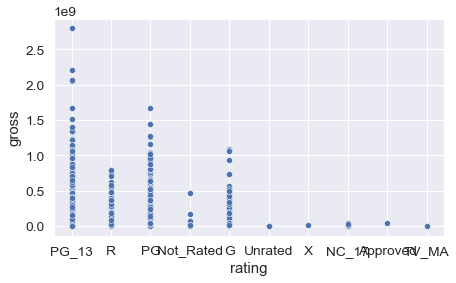

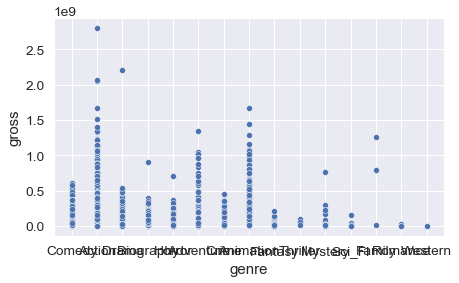

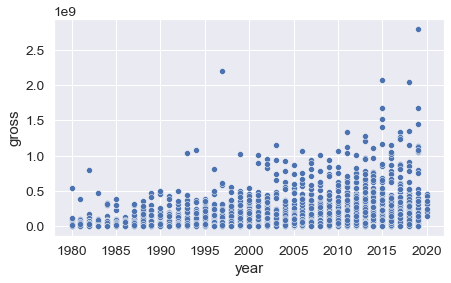

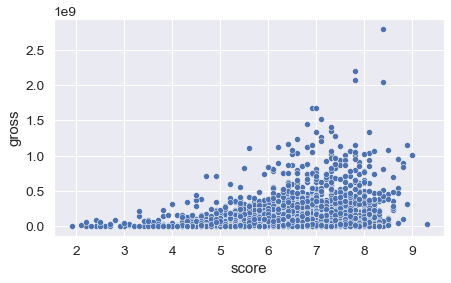

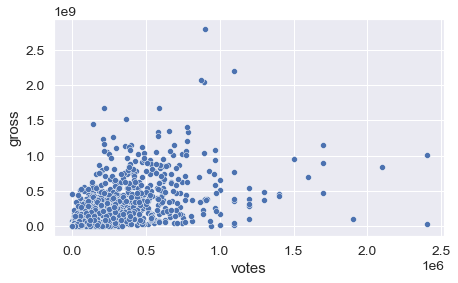

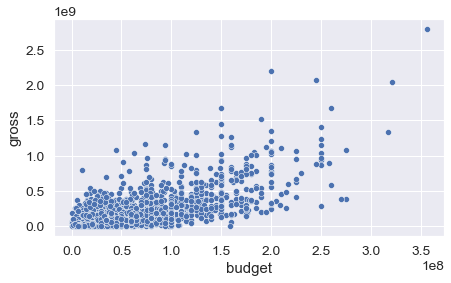

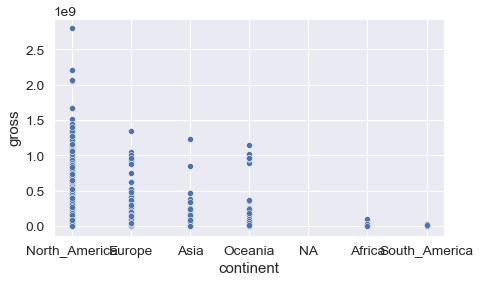

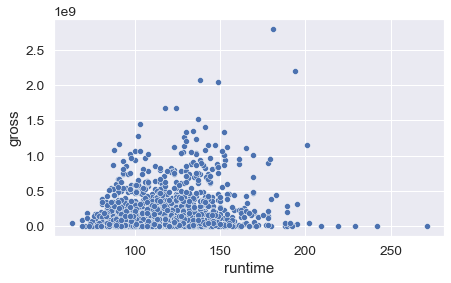

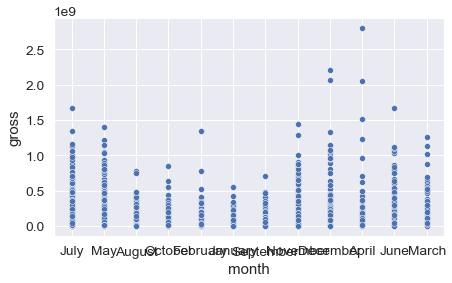

In [82]:
cols = ['rating','genre','year','score','votes','budget','continent','runtime', 'month']
for col in cols:
    plt.rcParams["figure.figsize"] = (7,4)
    sns.set(font_scale=1.25)
    sns.scatterplot(x = col, y = 'gross', data = train)
    plt.show()

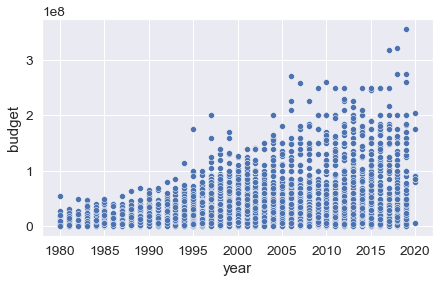

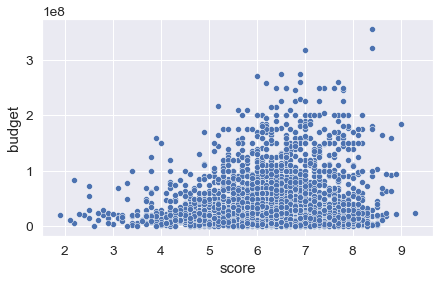

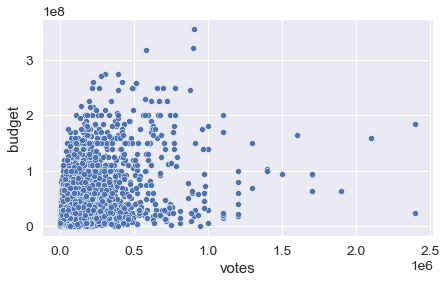

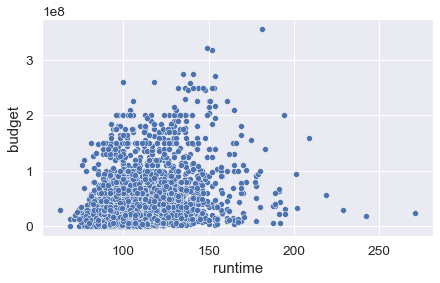

In [83]:
cols = ['year','score','votes','runtime']
for col in cols:
    plt.rcParams["figure.figsize"] = (7,4)
    sns.set(font_scale=1.25)
    sns.scatterplot(x = col, y = 'budget', data = train)
    plt.show()

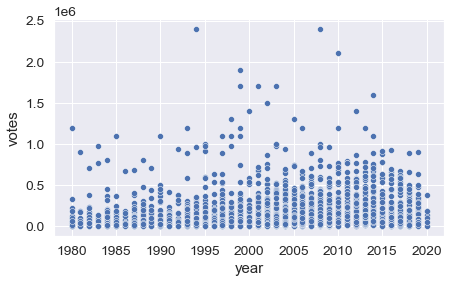

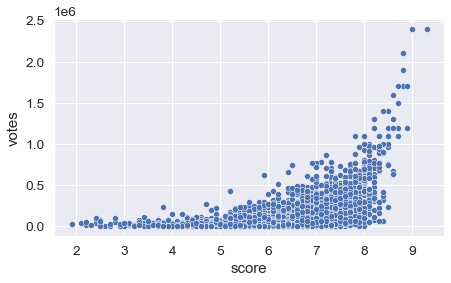

In [84]:
cols = ['year','score']
for col in cols:
    plt.rcParams["figure.figsize"] = (7,4)
    sns.set(font_scale=1.25)
    sns.scatterplot(x = col, y = 'votes', data = train)
    plt.show()

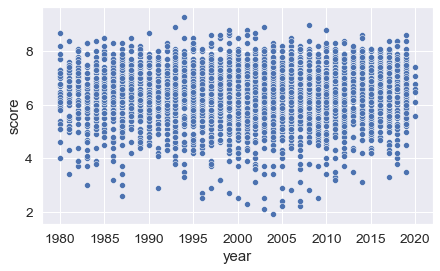

In [85]:
cols = ['year']
for col in cols:
    plt.rcParams["figure.figsize"] = (7,4)
    sns.set(font_scale=1.25)
    sns.scatterplot(x = col, y = 'score', data = train)
    plt.show()

/Users/lillysorkin/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


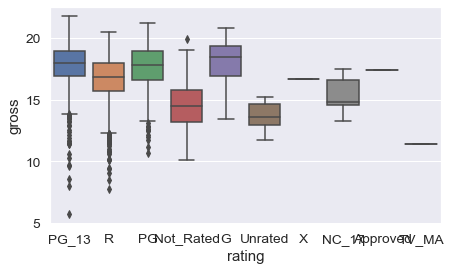

/Users/lillysorkin/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


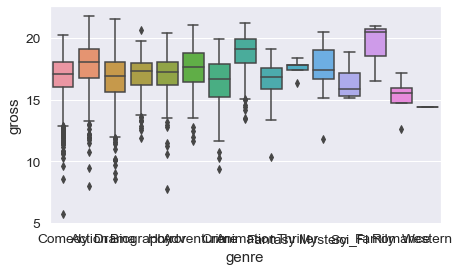

/Users/lillysorkin/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


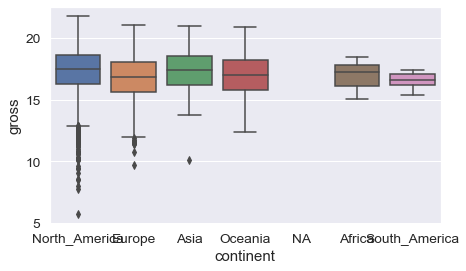

/Users/lillysorkin/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


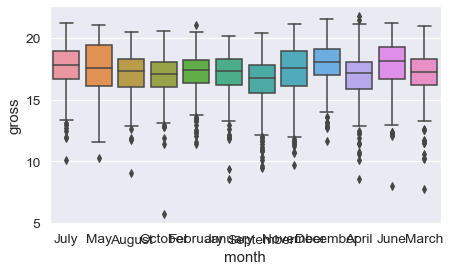

In [86]:
# visualizations of categorical variables vs gross
for col in ['rating','genre','continent', 'month']:
    sns.boxplot(x = col, y = np.log(train.gross), data = train)
    plt.show()

/Users/lillysorkin/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


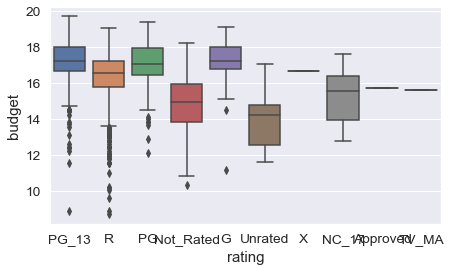

/Users/lillysorkin/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


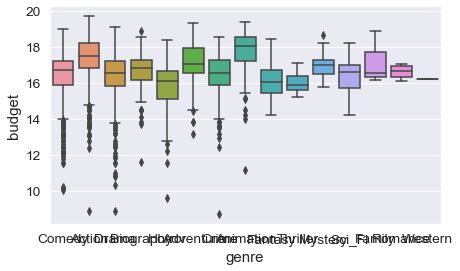

/Users/lillysorkin/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


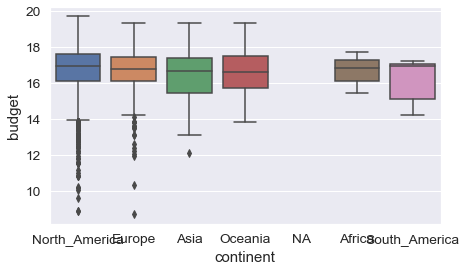

/Users/lillysorkin/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


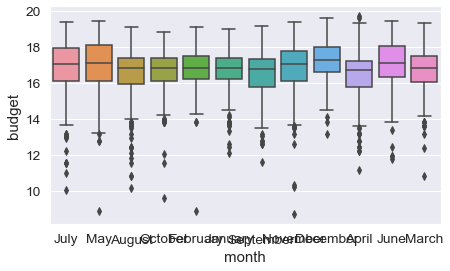

In [87]:
# visualizations of categorical variables vs gross
for col in ['rating','genre','continent', 'month']:
    sns.boxplot(x = col, y = np.log(train.budget), data = train)
    plt.show()

/Users/lillysorkin/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


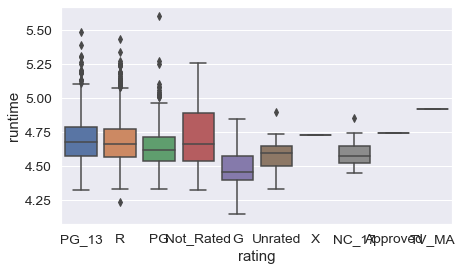

/Users/lillysorkin/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


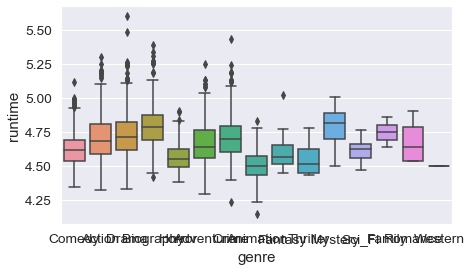

/Users/lillysorkin/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


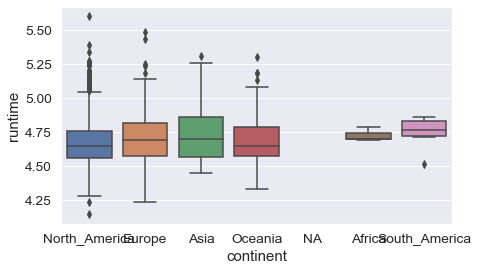

/Users/lillysorkin/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


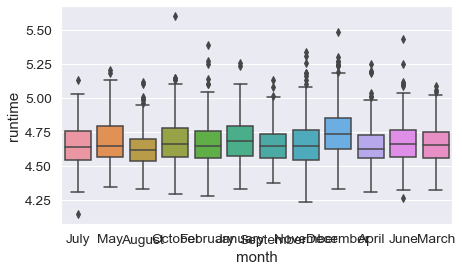

In [88]:
# visualizations of categorical variables vs gross
for col in ['rating','genre','continent','month']:
    sns.boxplot(x = col, y = np.log(train.runtime), data = train)
    plt.show()

/Users/lillysorkin/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


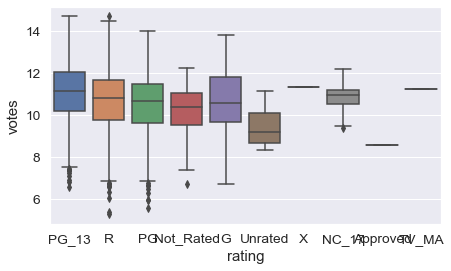

/Users/lillysorkin/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


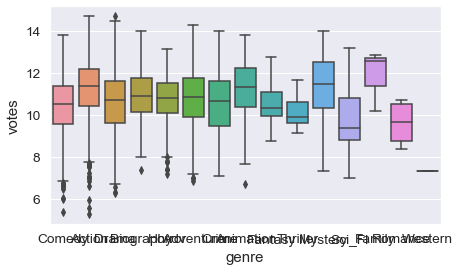

/Users/lillysorkin/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


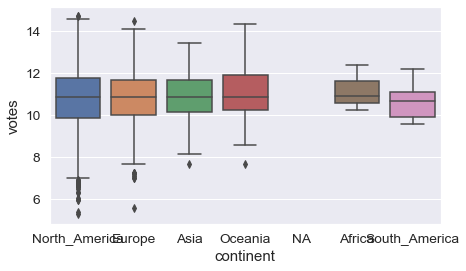

/Users/lillysorkin/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


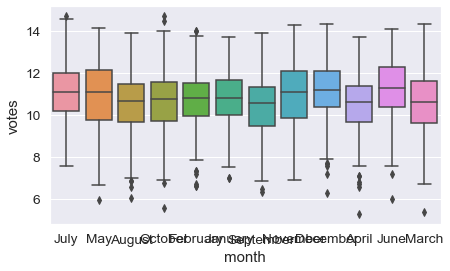

In [89]:
# visualizations of categorical variables vs gross
for col in ['rating','genre','continent', 'month']:
    sns.boxplot(x = col, y = np.log(train.votes), data = train)
    plt.show()

/Users/lillysorkin/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


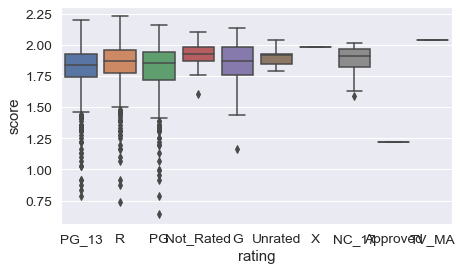

/Users/lillysorkin/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


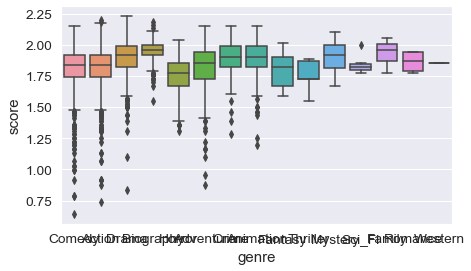

/Users/lillysorkin/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


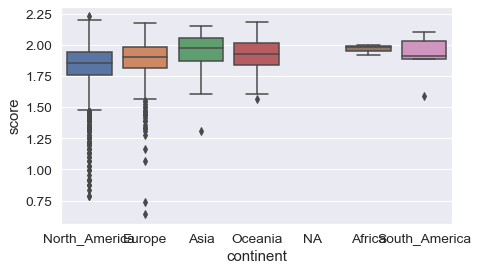

/Users/lillysorkin/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


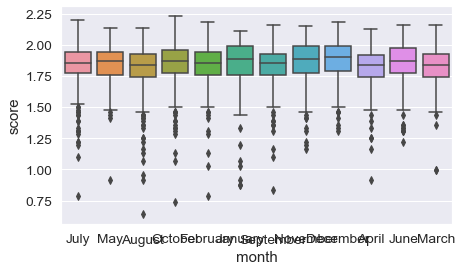

In [90]:
# visualizations of categorical variables vs gross
for col in ['rating','genre','continent', 'month']:
    sns.boxplot(x = col, y = np.log(train.score), data = train)
    plt.show()

In [91]:
train.corrwith(train.gross).sort_values(ascending = False)

gross      1.000000
budget     0.744424
votes      0.622532
year       0.273926
runtime    0.272756
score      0.225629
dtype: float64

In [92]:
train.corrwith(train.budget).sort_values(ascending = False)

budget     1.000000
gross      0.744424
votes      0.451081
year       0.327080
runtime    0.319284
score      0.070442
dtype: float64

In [93]:
train.corrwith(train.votes).sort_values(ascending = False)

votes      1.000000
gross      0.622532
score      0.475611
budget     0.451081
runtime    0.354783
year       0.209997
dtype: float64

## MULTICOLLINEARITY CHECK

In [94]:
train.dropna(inplace=True)

In [95]:
# doing VIF to see if there is multicollinearity
X = train[['year', 'votes', 'score', 'runtime', 'budget']]

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
X = add_constant(X)
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns

for i in range(len(X.columns)):
    vif_data.loc[i,'VIF'] = variance_inflation_factor(X.values, i)

print(vif_data)

   feature           VIF
0    const  40986.943137
1     year      1.129719
2    votes      1.685645
3    score      1.514187
4  runtime      1.348250
5   budget      1.498574


In [96]:
# There is very little collinearity.

Text(0.5, 1.0, 'Heatmap of Predictors')

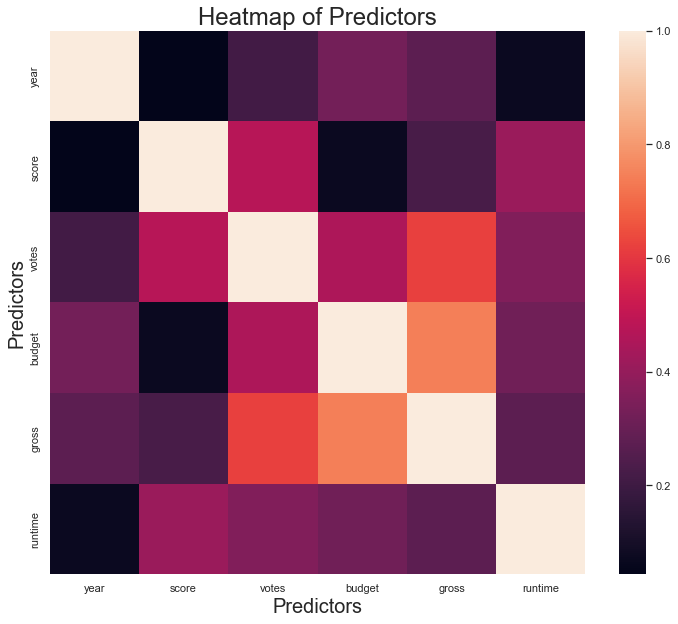

In [97]:
sns.set(rc={'figure.figsize':(12,10)})
sns.heatmap(train.corr())
plt.xlabel('Predictors', fontsize=20)
plt.ylabel('Predictors',fontsize=20)
plt.title('Heatmap of Predictors', fontsize=24)

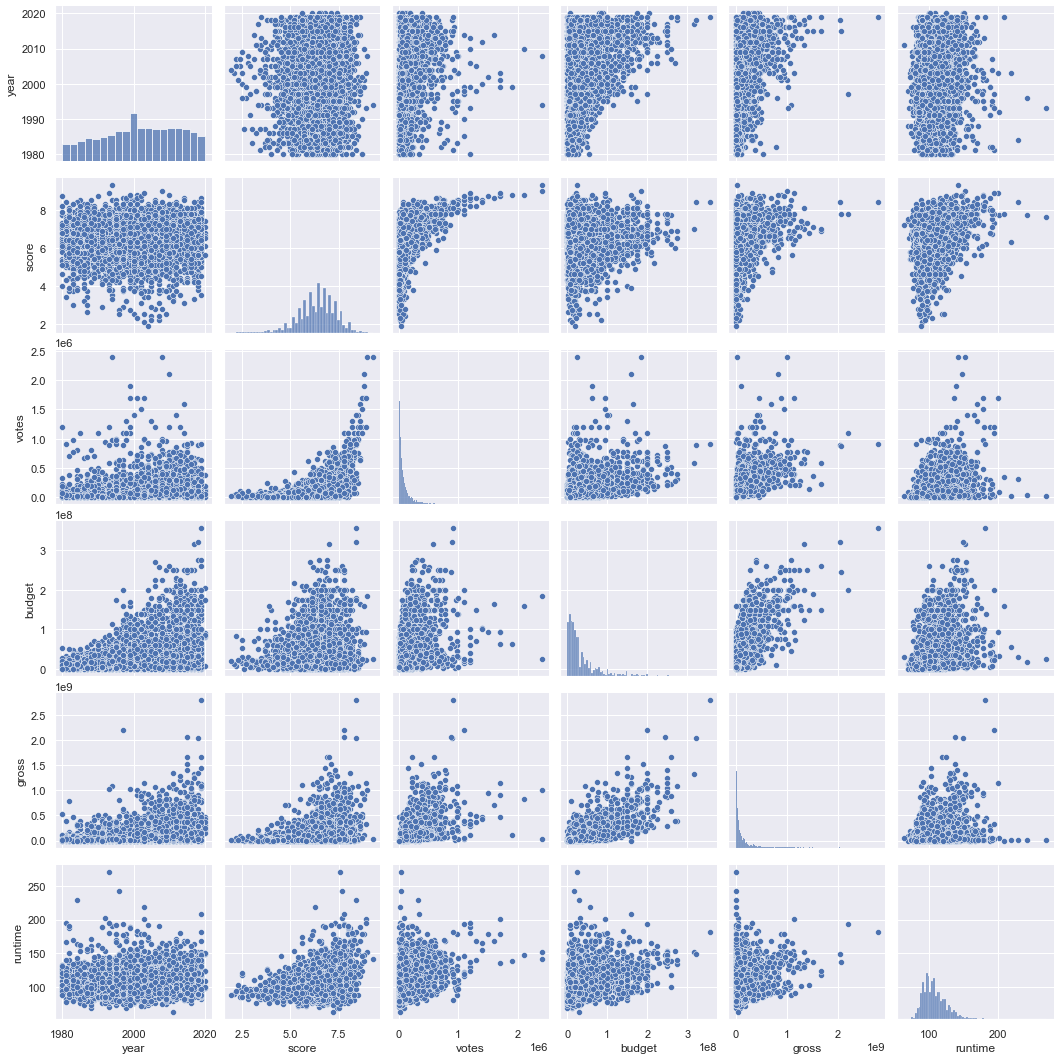

In [98]:
sns.pairplot(train)

# Pairplot indicates curvature in gross - resembles parabaloid 

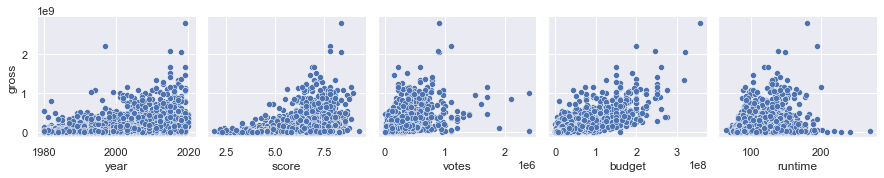

In [99]:
# Pairplot for gross

sns.pairplot(train, x_vars=['year', 'score', 'votes', 'budget', 'runtime'], y_vars=['gross'])

In [100]:
def dummies_for_categories(df):
    rating_dummy = pd.get_dummies(df['rating'])
    df = pd.concat([df, rating_dummy], axis=1)
    df = df.drop('rating', axis=1)
    genre_dummy = pd.get_dummies(df['genre'])
    df = pd.concat([df, genre_dummy], axis=1)
    df = df.drop('genre', axis=1)
    country_dummy = pd.get_dummies(df['country'])
    df = pd.concat([df, country_dummy], axis=1)
    df = df.drop('country', axis=1)
    month_dummy = pd.get_dummies(df['month'])
    df = pd.concat([df, month_dummy], axis=1)
    df = df.drop('month', axis=1)
    return df

train = dummies_for_categories(train)
test = dummies_for_categories(test)

In [134]:
movies_w = pd.read_csv('movie_industry_clean.csv')
movies_w.country.unique()

array(['United_Kingdom', 'United_States', 'South_Africa', 'West_Germany',
       'Canada', 'Australia', 'Italy', 'South_Korea', 'Sweden', 'Spain',
       'Hong_Kong', 'Mexico', 'Switzerland', nan, 'France', 'New_Zealand',
       'Japan', 'Yugoslavia', 'Ireland', 'Germany', 'Austria', 'Portugal',
       'China', 'Taiwan', 'Republic_of_Macedonia', 'Russia',
       'Federal_Republic_of_Yugoslavia', 'Czech_Republic', 'Iran',
       'Denmark', 'Jamaica', 'Brazil', 'Aruba', 'Argentina', 'India',
       'Netherlands', 'Colombia', 'Norway', 'Israel', 'Belgium',
       'United_Arab_Emirates', 'Indonesia', 'Hungary', 'Kenya', 'Iceland',
       'Chile', 'Finland', 'Panama', 'Malta', 'Lebanon', 'Thailand'],
      dtype=object)

In [138]:
train.countries.unique()

array(['United_States', 'United_Kingdom', 'France', 'Germany', 'Belgium',
       'Spain', 'Japan', 'Australia', 'New_Zealand', 'China', 'Canada',
       'other', 'Norway', 'Mexico', 'Ireland', 'Italy', 'South_Korea',
       'Hong_Kong', 'India', 'Czech_Republic', 'Taiwan', 'South_Africa',
       'Argentina', 'Indonesia', 'Brazil', 'Sweden', 'Russia',
       'Netherlands', 'Denmark'], dtype=object)

In [151]:
#Creating a set of predictors from which we need to find the best subset of predictors
X = train[['year','score','votes','budget','runtime','United_States', 'United_Kingdom',
           'France', 'Germany', 'Belgium', 'Spain', 'Japan', 'Australia', 'New_Zealand',
           'China', 'Canada','Norway', 'Mexico', 'Ireland', 'Italy', 'South_Korea',
           'Hong_Kong', 'India', 'Czech_Republic', 'Taiwan', 'South_Africa', 
           'Argentina', 'Indonesia', 'Brazil', 'Sweden', 'Russia','Netherlands', 
           'Denmark', 'Comedy', 'Action', 'Drama', 'Biography','Horror', 'Adventure', 
           'Crime', 'Animation', 'Fantasy', 'Thriller', 'Mystery', 'Sci_Fi', 'Family',
           'Romance', 'Western','PG_13', 'R', 'PG','Not_Rated', 'G', 'Unrated', 'X', 
           'NC_17', 'TV_MA', 'January', 'February', 'March', 'April', 'May',
           'June', 'July', 'August','September', 'October', 'November', 'December']]

In [152]:
#Function to develop a model based on all predictors in predictor_subset
def processSubset(predictor_subset):
    # Fit model on feature_set and calculate R-squared
    model = smf.ols('gross~' + '+'.join(predictor_subset),data = train).fit()
    Rsquared = model.rsquared
    return {"model":model, "Rsquared":Rsquared}

In [153]:
#Function to select the best model amongst all models with 'k' predictors
def getBest_model(k):
    tic = time.time()
    results = []
    for combo in itertools.combinations(X.columns, k):
        results.append(processSubset((list(combo))))

    # Wrap everything up in a dataframe
    models = pd.DataFrame(results)

    # Choose the model with the highest RSS
    best_model = models.loc[models['Rsquared'].argmax()]
    
    toc = time.time()
    print("Processed", models.shape[0], "models on", k, "predictors in", (toc-tic), "seconds.")
    return best_model

In [154]:
def best_sub_plots():
    plt.figure(figsize=(20,10))
    plt.rcParams.update({'font.size': 18, 'lines.markersize': 10})

    # Set up a 2x2 grid so we can look at 4 plots at once
    plt.subplot(2, 2, 1)

    # We will now plot a red dot to indicate the model with the largest adjusted R^2 statistic.
    # The argmax() function can be used to identify the location of the maximum point of a vector
    plt.plot(models_best["Rsquared"])
    plt.xlabel('# Predictors')
    plt.ylabel('Rsquared')

    # We will now plot a red dot to indicate the model with the largest adjusted R^2 statistic.
    # The argmax() function can be used to identify the location of the maximum point of a vector

    rsquared_adj = models_best.apply(lambda row: row[1].rsquared_adj, axis=1)

    plt.subplot(2, 2, 2)
    plt.plot(rsquared_adj)
    plt.plot(1+rsquared_adj.argmax(), rsquared_adj.max(), "or")
    plt.xlabel('# Predictors')
    plt.ylabel('adjusted rsquared')

    # We'll do the same for AIC and BIC, this time looking for the models with the SMALLEST statistic
    aic = models_best.apply(lambda row: row[1].aic, axis=1)

    plt.subplot(2, 2, 3)
    plt.plot(aic)
    plt.plot(1+aic.argmin(), aic.min(), "or")
    plt.xlabel('# Predictors')
    plt.ylabel('AIC')

    bic = models_best.apply(lambda row: row[1].bic, axis=1)

    plt.subplot(2, 2, 4)
    plt.plot(bic)
    plt.plot(1+bic.argmin(), bic.min(), "or")
    plt.xlabel('# Predictors')
    plt.ylabel('BIC')

## FORWARD STEPWISE SELECTION using COUNTRYs (scroll to bottom for continents)

In [155]:
#Function to find the best predictor out of p-k predictors and add it to the model containing the k predictors
def forward(predictors):

    # Pull out predictors we still need to process
    remaining_predictors = [p for p in X.columns if p not in predictors]
    
    tic = time.time()
    
    results = []
    
    for p in remaining_predictors:
        results.append(processSubset(predictors+[p]))
    
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    
    # Choose the model with the highest RSS
    best_model = models.loc[models['Rsquared'].argmax()]
    
    toc = time.time()
    print("Processed ", models.shape[0], "models on", len(predictors)+1, "predictors in", (toc-tic), "seconds.")
    
    # Return the best model, along with some other useful information about the model
    return best_model

In [156]:
def forward_selection():
    models_best = pd.DataFrame(columns=["Rsquared", "model"])

    tic = time.time()
    predictors = []

    for i in range(1,len(X.columns)+1):    
        models_best.loc[i] = forward(predictors)
        predictors = list(models_best.loc[i]["model"].params.index[1:])

    toc = time.time()
    print("Total elapsed time:", (toc-tic), "seconds.")
    return models_best

In [157]:
models_best = forward_selection()

Processed  69 models on 1 predictors in 0.4040539264678955 seconds.
Processed  68 models on 2 predictors in 0.43708300590515137 seconds.
Processed  67 models on 3 predictors in 0.48808884620666504 seconds.
Processed  66 models on 4 predictors in 0.5002601146697998 seconds.
Processed  65 models on 5 predictors in 0.5637540817260742 seconds.
Processed  64 models on 6 predictors in 0.6388142108917236 seconds.
Processed  63 models on 7 predictors in 0.6738560199737549 seconds.
Processed  62 models on 8 predictors in 0.7313268184661865 seconds.
Processed  61 models on 9 predictors in 0.7643098831176758 seconds.
Processed  60 models on 10 predictors in 0.8363478183746338 seconds.
Processed  59 models on 11 predictors in 0.8572549819946289 seconds.
Processed  58 models on 12 predictors in 0.8986270427703857 seconds.
Processed  57 models on 13 predictors in 0.9382619857788086 seconds.
Processed  56 models on 14 predictors in 0.9961040019989014 seconds.
Processed  55 models on 15 predictors in 

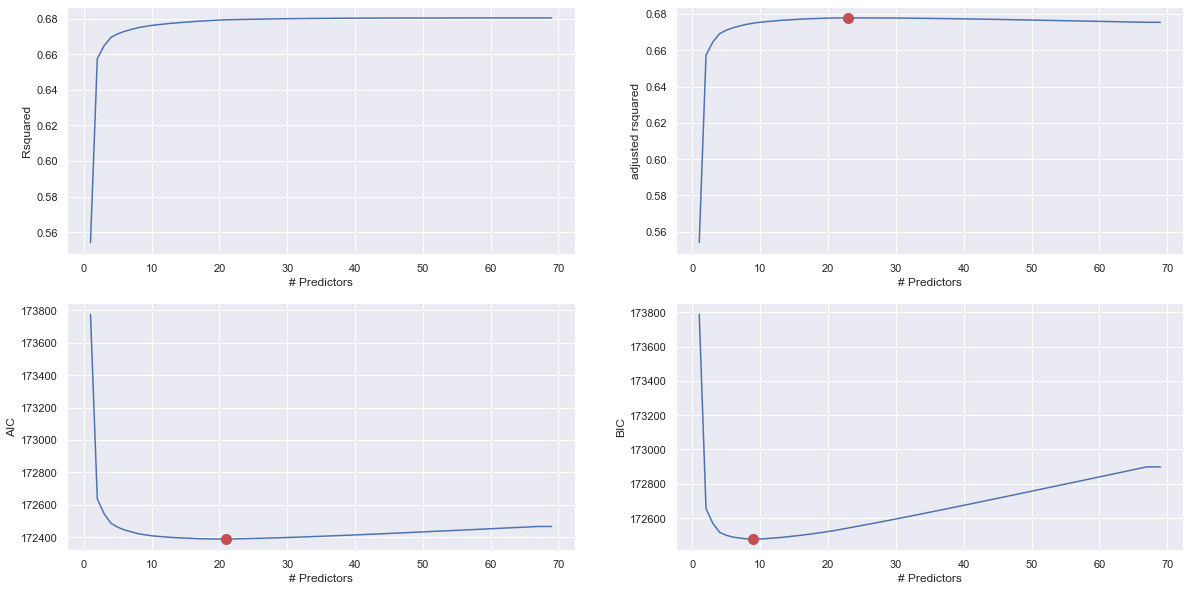

In [158]:
best_sub_plots()

In [159]:
models_best.sort_values('Rsquared', ascending=False)

,Rsquared,model
67,0.680367,<statsmodels.regression.linear_model.Regressio...
69,0.680367,<statsmodels.regression.linear_model.Regressio...
68,0.680367,<statsmodels.regression.linear_model.Regressio...
66,0.680367,<statsmodels.regression.linear_model.Regressio...
65,0.680367,<statsmodels.regression.linear_model.Regressio...
...,...,...
5,0.67141,<statsmodels.regression.linear_model.Regressio...
4,0.6694,<statsmodels.regression.linear_model.Regressio...
3,0.664718,<statsmodels.regression.linear_model.Regressio...
2,0.657388,<statsmodels.regression.linear_model.Regressio...


In [160]:
best_fwd_reg_model1 = models_best['model'][67]
best_fwd_reg_model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  gross   R-squared:                       0.680
Model:                            OLS   Adj. R-squared:                  0.675
Method:                 Least Squares   F-statistic:                     135.5
Date:                Sun, 12 Mar 2023   Prob (F-statistic):               0.00
Time:                        04:33:55   Log-Likelihood:                -86165.
No. Observations:                4332   AIC:                         1.725e+05
Df Residuals:                    4264   BIC:                         1.729e+05
Df Model:                          67                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept      -6.482e+08   3.76e+08     -1.723      0.085   -1.39e+09    8.95e+07
budget             2.4650      0.057     43.442      0.000       2.354       2.576
votes            359.8875     11.878     30.299      0.000     336.601     383.174
Animation       6.161e+07   1.07e+08      0.578      0.563   -1.47e+08    2.71e+08
Family          4.741e+08   1.23e+08      3.865      0.000    2.34e+08    7.15e+08
R              -7.104e+07   1.07e+08     -0.666      0.506    -2.8e+08    1.38e+08
Horror          3.735e+07   1.07e+08      0.350      0.726   -1.72e+08    2.46e+08
Comedy          9.421e+06   1.06e+08      0.089      0.929   -1.99e+08    2.18e+08
October        -1.344e+07   7.74e+06     -1.737      0.082   -2.86e+07    1.73e+06
Germany        -2.884e+07   2.38e+07     -1.213      0.225   -7.54e+07    1.78e+07
New_Zealand         8e+07    3.3e+07      2.423      0.015    1.53e+07    1.45e+08
May             2.102e+07   8.34e+06      2.518      0.012    4.66e+06    3.74e+07
score           6.605e+06   2.25e+06      2.941      0.003     2.2e+06     1.1e+07
July             1.81e+07   8.14e+06      2.223      0.026    2.14e+06    3.41e+07
China           5.207e+07   3.28e+07      1.588      0.112   -1.22e+07    1.16e+08
PG              -4.67e+07   1.07e+08     -0.438      0.662   -2.56e+08    1.62e+08
United_States   5.862e+06   2.03e+07      0.289      0.773   -3.39e+07    4.56e+07
April           1.414e+07   8.17e+06      1.732      0.083   -1.87e+06    3.01e+07
year            3.182e+05   1.74e+05      1.832      0.067   -2.23e+04    6.59e+05
June            1.297e+07   8.26e+06      1.569      0.117   -3.23e+06    2.92e+07
Biography      -1.277e+07   1.07e+08     -0.120      0.905   -2.22e+08    1.96e+08
Canada          1.226e+07   2.32e+07      0.527      0.598   -3.33e+07    5.78e+07
Fantasy         1.629e+07   1.08e+08      0.151      0.880   -1.96e+08    2.28e+08
Taiwan          7.145e+07   7.78e+07      0.918      0.359   -8.11e+07    2.24e+08
Belgium        -7.811e+07   7.79e+07     -1.003      0.316   -2.31e+08    7.46e+07
France         -1.626e+07   2.32e+07     -0.700      0.484   -6.18e+07    2.93e+07
December        7.706e+06   8.23e+06      0.936      0.349   -8.43e+06    2.38e+07
Thriller        4.121e+07   1.17e+08      0.354      0.724   -1.87e+08     2.7e+08
Denmark        -3.737e+07   4.09e+07     -0.913      0.361   -1.18e+08    4.29e+07
Mexico          2.745e+07   3.93e+07      0.699      0.485   -4.95e+07    1.04e+08
Australia      -1.851e+07   2.72e+07     -0.681      0.496   -7.18e+07    3.48e+07
November        4.494e+06      8e+06      0.562      0.574   -1.12e+07    2.02e+07
Czech_Republic -3.486e+07   5.17e+07     -0.674      0.500   -1.36e+08    6.65e+07
runtime        -9.648e+04   1.19e+05     -0.810      0.418    -3.3e+05    1.37e+05
Ireland     

In [167]:
best_fwd_reg_model1.pvalues.sort_values(ascending=False)

Adventure     9.905837e-01
Drama         9.904185e-01
Norway        9.743403e-01
Sweden        9.743185e-01
Brazil        9.695504e-01
                 ...      
May           1.182254e-02
score         3.285571e-03
Family        1.129290e-04
votes        8.260854e-183
budget        0.000000e+00
Length: 68, dtype: float64

In [161]:
#Finding the RMSE of the model selected using the forward selection procedure, where the predictors
#include 2-factor interactions
pred_gross = best_fwd_reg_model1.predict(test)
np.sqrt(((pred_gross - test.gross)**2).mean())

PatsyError: predict requires that you use a DataFrame when predicting from a model
that was created using the formula api.

The original error message returned by patsy is:
when evaluating factor X, I got 1 columns instead of the 69 I was expecting
    gross~budget+votes+Animation+Family+R+Horror+Comedy+October+Germany+New_Zealand+May+score+July+China+PG+United_States+April+year+June+Biography+Canada+Fantasy+Taiwan+Belgium+France+December+Thriller+Denmark+Mexico+Australia+November+Czech_Republic+runtime+Ireland+Not_Rated+Adventure+Drama+January+X+Unrated+August+Sci_Fi+Spain+Hong_Kong+Mystery+G+India+Italy+March+Netherlands+Russia+Japan+South_Korea+NC_17+PG_13+TV_MA+Indonesia+February+Romance+Argentina+United_Kingdom+Crime+South_Africa+Action+Brazil+Sweden+Norway
                                                                                                                                                                                                                                                                                                              ^

## BACKWARDS STEPWISE SELECTION using COUNTRYs (scroll to bottom for continents)

In [162]:
def backward(predictors):
    
    tic = time.time()
    
    results = []
    
    for combo in itertools.combinations(predictors, len(predictors)-1):
        results.append(processSubset(combo))
    
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    
    # Choose the model with the highest RSS
    best_model = models.loc[models['Rsquared'].argmax()]
    
    toc = time.time()
    print("Processed ", models.shape[0], "models on", len(predictors)-1, "predictors in", (toc-tic), "seconds.")
    
    # Return the best model, along with some other useful information about the model
    return best_model

In [163]:
def backward_selection():
    models_best = pd.DataFrame(columns=["Rsquared", "model"], index = range(1,len(X.columns)))

    tic = time.time()
    predictors = X.columns
    models_best.loc[len(predictors)] = processSubset(predictors)
    
    while(len(predictors) > 1):  
        models_best.loc[len(predictors)-1] = backward(predictors)
        predictors = models_best.loc[len(predictors)-1]["model"].params.index[1:]

    toc = time.time()
    print("Total elapsed time:", (toc-tic), "seconds.")
    return models_best

In [164]:
models_best = backward_selection()

Processed  69 models on 68 predictors in 6.5591230392456055 seconds.
Processed  68 models on 67 predictors in 6.276871919631958 seconds.
Processed  67 models on 66 predictors in 6.2170729637146 seconds.
Processed  66 models on 65 predictors in 5.948718070983887 seconds.
Processed  65 models on 64 predictors in 5.5769877433776855 seconds.
Processed  64 models on 63 predictors in 5.410161018371582 seconds.
Processed  63 models on 62 predictors in 5.596018075942993 seconds.
Processed  62 models on 61 predictors in 5.619851112365723 seconds.
Processed  61 models on 60 predictors in 5.052508115768433 seconds.
Processed  60 models on 59 predictors in 4.651113986968994 seconds.
Processed  59 models on 58 predictors in 4.769877910614014 seconds.
Processed  58 models on 57 predictors in 4.10529899597168 seconds.
Processed  57 models on 56 predictors in 4.325878858566284 seconds.
Processed  56 models on 55 predictors in 5.252648115158081 seconds.
Processed  55 models on 54 predictors in 4.778161

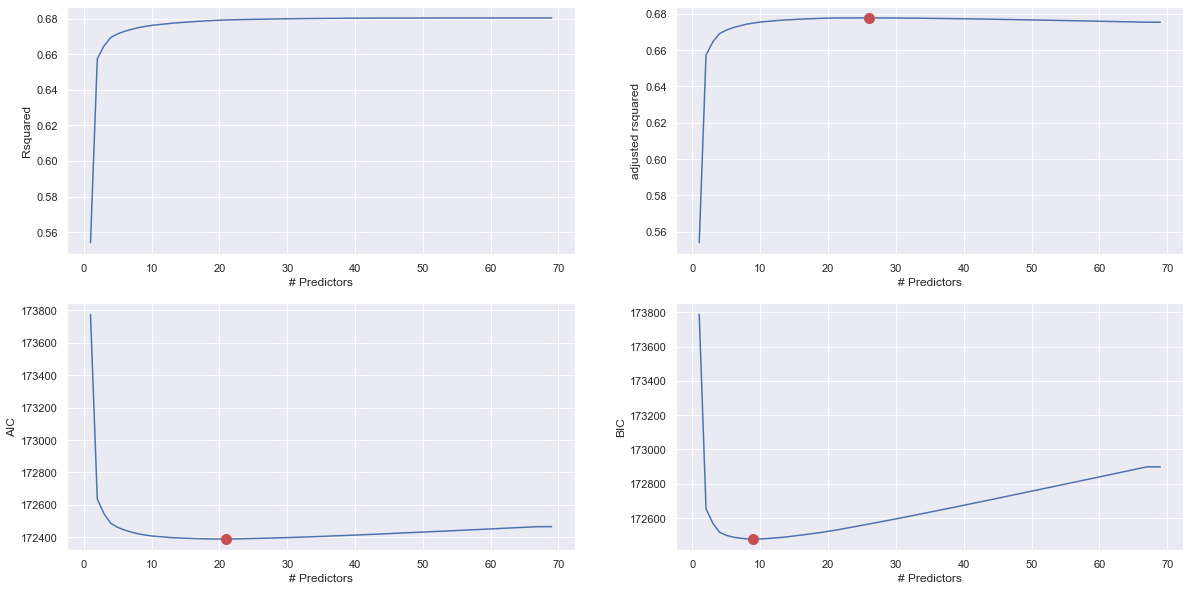

In [165]:
best_sub_plots()

In [193]:
best_bwd_reg_model3 = models_best['model'][9]
best_bwd_reg_model3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  gross   R-squared:                       0.676
Model:                            OLS   Adj. R-squared:                  0.675
Method:                 Least Squares   F-statistic:                     999.9
Date:                Sun, 12 Mar 2023   Prob (F-statistic):               0.00
Time:                        04:50:01   Log-Likelihood:                -86197.
No. Observations:                4332   AIC:                         1.724e+05
Df Residuals:                    4322   BIC:                         1.725e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -2.662e+07   3.61e+06     -7.368      0.000   -3.37e+07   -1.95e+07
votes        380.9431     10.018     38.026      0.000     361.303     400.583
budget         2.4607      0.047     52.136      0.000       2.368       2.553
Europe     -1.393e+07    4.6e+06     -3.028      0.002   -2.29e+07   -4.91e+06
Comedy      1.316e+07   3.79e+06      3.475      0.001    5.73e+06    2.06e+07
Horror      3.737e+07   7.86e+06      4.758      0.000     2.2e+07    5.28e+07
Animation   7.267e+07   7.71e+06      9.428      0.000    5.76e+07    8.78e+07
Family       4.84e+08   6.13e+07      7.890      0.000    3.64e+08    6.04e+08
R            -1.7e+07   3.49e+06     -4.876      0.000   -2.38e+07   -1.02e+07
October    -1.963e+07   5.49e+06     -3.579      0.000   -3.04e+07   -8.88e+06
==============================================================================
Omnibus:                     3391.792   Durbin-Watson:                   2.022
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           248530.926
Skew:                           3.164   Prob(JB):                         0.00
Kurtosis:                      39.563   Cond. No.                     2.09e+09
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.09e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [170]:
best_bwd_reg_model3.pvalues.sort_values(ascending=False)

Adventure       9.905836e-01
Drama           9.904186e-01
Norway          9.743403e-01
Sweden          9.743185e-01
Brazil          9.695504e-01
                   ...      
New_Zealand     1.542304e-02
score           3.285572e-03
Family          1.129289e-04
votes          8.260819e-183
budget          0.000000e+00
Length: 69, dtype: float64

# would say that the most important variables seem to be genre, rating, votes, budget, month

In [194]:
best_fwd_reg_model4 = models_best['model'][21]
best_fwd_reg_model4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  gross   R-squared:                       0.678
Model:                            OLS   Adj. R-squared:                  0.677
Method:                 Least Squares   F-statistic:                     433.1
Date:                Sun, 12 Mar 2023   Prob (F-statistic):               0.00
Time:                        04:50:17   Log-Likelihood:                -86177.
No. Observations:                4332   AIC:                         1.724e+05
Df Residuals:                    4310   BIC:                         1.725e+05
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -7.655e+08   3.36e+08     -2.276      0.023   -1.42e+09   -1.06e+08
year         3.45e+05   1.68e+05      2.056      0.040    1.61e+04    6.74e+05
score       6.654e+06   2.05e+06      3.242      0.001    2.63e+06    1.07e+07
votes        360.2852     11.657     30.907      0.000     337.431     383.139
budget         2.4457      0.050     48.719      0.000       2.347       2.544
Europe     -1.532e+07   4.64e+06     -3.304      0.001   -2.44e+07   -6.23e+06
Comedy      1.345e+07   3.97e+06      3.391      0.001    5.67e+06    2.12e+07
Biography  -9.982e+06   7.35e+06     -1.358      0.175   -2.44e+07    4.43e+06
Horror      4.214e+07      8e+06      5.269      0.000    2.65e+07    5.78e+07
Adventure   6.584e+06   7.29e+06      0.903      0.366   -7.71e+06    2.09e+07
Animation   6.556e+07   8.17e+06      8.027      0.000    4.96e+07    8.16e+07
Fantasy     2.193e+07   1.98e+07      1.105      0.269    -1.7e+07    6.08e+07
Thriller     4.71e+07   4.74e+07      0.993      0.321   -4.59e+07     1.4e+08
Family      4.754e+08   6.13e+07      7.752      0.000    3.55e+08    5.96e+08
R           -1.46e+07    3.8e+06     -3.846      0.000    -2.2e+07   -7.16e+06
PG          1.109e+07   5.18e+06      2.142      0.032    9.42e+05    2.12e+07
June        1.132e+07   6.25e+06      1.810      0.070   -9.44e+05    2.36e+07
July        1.702e+07   6.12e+06      2.783      0.005    5.03e+06     2.9e+07
May         1.996e+07   6.37e+06      3.132      0.002    7.47e+06    3.25e+07
December    7.217e+06   6.16e+06      1.171      0.242   -4.87e+06    1.93e+07
October    -1.432e+07   5.66e+06     -2.530      0.011   -2.54e+07   -3.22e+06
April        1.31e+07   6.19e+06      2.115      0.034    9.57e+05    2.52e+07
==============================================================================
Omnibus:                     3430.506   Durbin-Watson:                   2.024
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           253960.736
Skew:                           3.220   Prob(JB):                         0.00
Kurtosis:                      39.953   Cond. No.                     1.15e+10
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.15e+10. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [195]:
#Finding the RMSE of the model selected using the forward selection procedure, where the predictors
#include 2-factor interactions
pred_gross = best_bwd_reg_model3.predict(test)
np.sqrt(((pred_gross - test.gross)**2).mean())

# this doesn't run cuz the test data does not have a movie of the "Sci_Fi" genre in it

117466825.38813007

In [175]:
test.columns

Index(['name', 'year', 'released', 'score', 'votes', 'director', 'writer',
       'star', 'budget', 'gross', 'company', 'runtime', 'continent',
       'countries', 'G', 'NC_17', 'Not_Rated', 'PG', 'PG_13', 'R', 'TV_MA',
       'Unrated', 'Action', 'Adventure', 'Animation', 'Biography', 'Comedy',
       'Crime', 'Drama', 'Family', 'Fantasy', 'Horror', 'Mystery', 'Romance',
       'Thriller', 'Western', 'Argentina', 'Australia', 'Belgium', 'Brazil',
       'Canada', 'China', 'Colombia', 'Czech_Republic', 'Denmark', 'France',
       'Germany', 'Hong_Kong', 'India', 'Indonesia', 'Ireland', 'Italy',
       'Japan', 'Malta', 'Mexico', 'Netherlands', 'New_Zealand', 'Norway',
       'Portugal', 'Russia', 'South_Africa', 'South_Korea', 'Spain', 'Sweden',
       'Taiwan', 'Thailand', 'United_Kingdom', 'United_States', 'April',
       'August', 'December', 'February', 'January', 'July', 'June', 'March',
       'May', 'November', 'October', 'September'],
      dtype='object')

In [176]:
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn.preprocessing import StandardScaler 
from sklearn.metrics import r2_score

## RIDGE - was not successful - disregard

In [177]:
y = train.gross

In [47]:
#Standardizing predictors so that each of them have zero mean and unit variance

# Dropping `United_States`, `Action`, and `PG_13` predictors to avoid multicollinearity
X = train.loc[:,['year','score','votes','budget','runtime','United_States', 'United_Kingdom', 'France', 'Germany', 'Belgium',
       'Spain', 'Japan', 'Australia', 'New_Zealand', 'China', 'Canada',
       'Austria', 'Norway', 'Iceland', 'West_Germany', 'Mexico',
       'Ireland', 'Italy', 'South_Korea', 'Hong_Kong', 'India',
       'United_Arab_Emirates', 'Czech_Republic', 'Finland', 'Taiwan',
       'Lebanon', 'South_Africa', 'Argentina', 'Indonesia', 'Iran',
       'Switzerland', 'Brazil', 'Republic_of_Macedonia', 'Sweden',
       'Russia', 'Netherlands', 'Aruba', 'Jamaica', 'Chile', 'Panama',
       'Denmark', 'Israel', 'Federal_Republic_of_Yugoslavia', 'Kenya',
       'Yugoslavia', 'Hungary','Comedy', 'Action', 'Drama', 'Biography', 'Horror', 'Adventure',
       'Crime', 'Animation', 'Fantasy', 'Thriller', 'Mystery', 'Sci_Fi',
       'Family', 'Romance', 'Western','PG_13', 'R', 'PG', 'Not_Rated', 'G', 'Unrated', 'X', 'NC_17',
       'Approved', 'TV_MA']]

#Defining a scaler object
scaler = StandardScaler()

#The scaler object will contain the mean and variance of each column (predictor) of X. 
#These values will be useful to scale test data based on the same mean and variance as obtained on train data
scaler.fit(X)

#Using the scaler object (or the values of mean and variance stored in it) to standardize X (or train data)
Xstd = scaler.transform(X)

In [48]:
#The tuning parameter lambda is referred as alpha in sklearn

#Creating a range of values of the tuning parameter to visualize the ridge regression coefficients
#for different values of the tuning parameter
alphas = 10**np.linspace(10,-2,200)*0.5

In [49]:
#Finding the ridge regression coefficients for increasing values of the tuning parameter
coefs = []
for a in alphas:        
    ridge = Ridge(alpha = a)
    ridge.fit(Xstd, y)
    coefs.append(ridge.coef_)

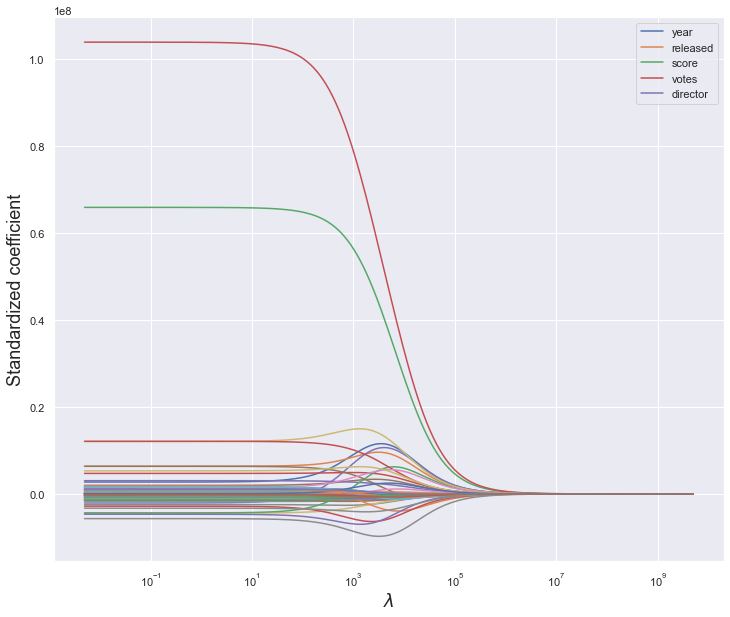

In [50]:
#Visualizing the shrinkage in ridge regression coefficients with increasing values of the tuning parameter lambda
plt.xlabel('xlabel', fontsize=18)
plt.ylabel('ylabel', fontsize=18)
plt.plot(alphas, coefs)
plt.xscale('log')
plt.xlabel('$\lambda$')
plt.ylabel('Standardized coefficient')
plt.legend(train.columns[1:6]);

In [51]:
#Let us use cross validation to find the optimal value of the tuning parameter - lambda
#For the optimal lambda, the cross validation error will be the least

#Note that we are reducing the range of alpha so as to better visualize the minimum
alphas = 10**np.linspace(1.5,-3,200)*0.5
ridgecv = RidgeCV(alphas = alphas,store_cv_values=True)
ridgecv.fit(Xstd, y)

#Optimal value of the tuning parameter - lamda
ridgecv.alpha_

/Users/aarti.pappu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:1791: RuntimeWarning: invalid value encountered in reciprocal
  w = ((singvals_sq + alpha) ** -1) - (alpha ** -1)


15.811388300841896

Text(0, 0.5, 'Cross-validation error')

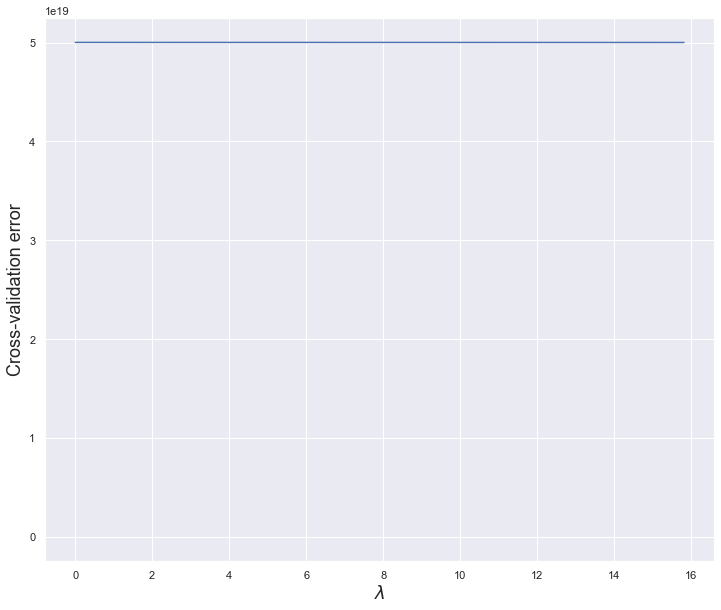

In [52]:
#Visualizing the LOOCV (leave one out cross validatation error vs lambda)
plt.xlabel('xlabel', fontsize=18)
plt.ylabel('ylabel', fontsize=18)
plt.plot(ridgecv.alphas,ridgecv.cv_values_.sum(axis=0))
plt.plot([ridgecv.alpha_,ridgecv.alpha_],[40,40.2],':')
plt.xlabel('$\lambda$')
plt.ylabel('Cross-validation error')

## LASSO - was not successful - disregard

In [54]:
#Creating a range of values of the tuning parameter to visualize the lasso coefficients
#for different values of the tuning parameter
alphas = 10**np.linspace(10,-2,100)*0.1

In [55]:
#Finding the lasso coefficients for increasing values of the tuning parameter
lasso = Lasso(max_iter = 10000)
coefs = []

for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(Xstd, y)
    coefs.append(lasso.coef_)

/Users/aarti.pappu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.111e+17, tolerance: 1.500e+16
  model = cd_fast.enet_coordinate_descent(
/Users/aarti.pappu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.110e+17, tolerance: 1.500e+16
  model = cd_fast.enet_coordinate_descent(
/Users/aarti.pappu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider incre

KeyboardInterrupt: 

In [ ]:
#Visualizing the shrinkage in lasso coefficients with increasing values of the tuning parameter lambda
plt.xlabel('xlabel', fontsize=18)
plt.ylabel('ylabel', fontsize=18)
plt.plot(alphas, coefs)
plt.xscale('log')
plt.xlabel('$\lambda$')
plt.ylabel('Standardized coefficient')
plt.legend(train.columns[1:6]);
#plt.plot([lassocv.alpha_,lassocv.alpha_],[-0.4,0.25],':')
plt.legend(train.columns[1:6]);

In [ ]:
#Let us use cross validation to find the optimal value of the tuning parameter - lambda
#For the optimal lambda, the cross validation error will be the least

#Note that we are reducing the range of alpha so as to better visualize the minimum
alphas = 10**np.linspace(-1,-5,200)*0.5
lassocv = LassoCV(alphas = alphas, cv = 10, max_iter = 100000)
lassocv.fit(Xstd, y)

#Optimal value of the tuning parameter - lamda
lassocv.alpha_

In [ ]:
#Visualizing the LOOCV (leave one out cross validatation error vs lambda)
plt.xlabel('xlabel', fontsize=18)
plt.ylabel('ylabel', fontsize=18)
plt.plot(lassocv.alphas_,lassocv.mse_path_.mean(axis=1))
plt.plot([lassocv.alpha_,lassocv.alpha_],[0.145,0.151],':')
plt.xlabel('$\lambda$')
plt.ylabel('Cross-validation error')

## FORWARD STEPWISE USING CONTINENTS

In [182]:
def dummies_for_continents(df):
    '''rating_dummy = pd.get_dummies(df['rating'])
    df = pd.concat([df, rating_dummy], axis=1)
    df = df.drop('rating', axis=1)
    genre_dummy = pd.get_dummies(df['genre'])
    df = pd.concat([df, genre_dummy], axis=1)
    df = df.drop('genre', axis=1)'''
    continent_dummy = pd.get_dummies(df['continent'])
    df = pd.concat([df, continent_dummy], axis=1)
    df = df.drop('continent', axis=1)
    return df

train = dummies_for_continents(train)
test = dummies_for_continents(test)

In [183]:
movies_w.month.unique()

array(['June', 'July', 'May', 'December', 'October', 'September',
       'February', 'April', 'August', 'March', 'November', 'January', nan],
      dtype=object)

In [184]:
#Creating a set of predictors from which we need to find the best subset of predictors
X = train[['year','score','votes','budget','runtime','North_America', 'Europe', 'Asia', 'Oceania', 'Africa',
       'South_America','Comedy', 'Action', 'Drama', 'Biography', 'Horror', 'Adventure',
       'Crime', 'Animation', 'Fantasy', 'Thriller', 'Mystery', 'Sci_Fi',
       'Family', 'Romance', 'Western','PG_13', 'R', 'PG', 'Not_Rated', 'G', 'Unrated', 'X', 'NC_17',
       'Approved', 'TV_MA', 'June', 'July', 'May', 'December', 'October', 'September',
       'February', 'April', 'August', 'March', 'November', 'January']]

In [185]:
models_best = forward_selection()

Processed  48 models on 1 predictors in 0.465029239654541 seconds.
Processed  47 models on 2 predictors in 0.6083340644836426 seconds.
Processed  46 models on 3 predictors in 0.6687908172607422 seconds.
Processed  45 models on 4 predictors in 0.6854422092437744 seconds.
Processed  44 models on 5 predictors in 0.7615187168121338 seconds.
Processed  43 models on 6 predictors in 0.8950629234313965 seconds.
Processed  42 models on 7 predictors in 0.9165596961975098 seconds.
Processed  41 models on 8 predictors in 0.9426531791687012 seconds.
Processed  40 models on 9 predictors in 0.9007260799407959 seconds.
Processed  39 models on 10 predictors in 0.9209110736846924 seconds.
Processed  38 models on 11 predictors in 1.18281888961792 seconds.
Processed  37 models on 12 predictors in 1.3184170722961426 seconds.
Processed  36 models on 13 predictors in 1.3533787727355957 seconds.
Processed  35 models on 14 predictors in 1.2159898281097412 seconds.
Processed  34 models on 15 predictors in 1.413

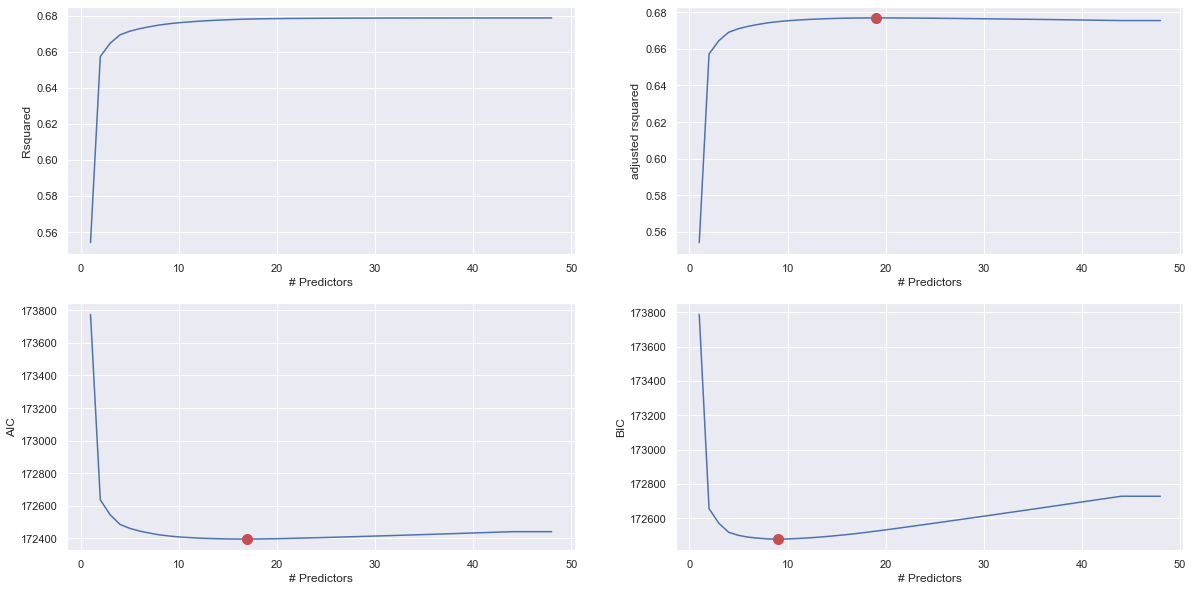

In [186]:
best_sub_plots()

In [196]:
best_fwd_reg_model5 = models_best['model'][9]
best_fwd_reg_model5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  gross   R-squared:                       0.676
Model:                            OLS   Adj. R-squared:                  0.675
Method:                 Least Squares   F-statistic:                     999.9
Date:                Sun, 12 Mar 2023   Prob (F-statistic):               0.00
Time:                        04:50:58   Log-Likelihood:                -86197.
No. Observations:                4332   AIC:                         1.724e+05
Df Residuals:                    4322   BIC:                         1.725e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -2.662e+07   3.61e+06     -7.368      0.000   -3.37e+07   -1.95e+07
votes        380.9431     10.018     38.026      0.000     361.303     400.583
budget         2.4607      0.047     52.136      0.000       2.368       2.553
Europe     -1.393e+07    4.6e+06     -3.028      0.002   -2.29e+07   -4.91e+06
Comedy      1.316e+07   3.79e+06      3.475      0.001    5.73e+06    2.06e+07
Horror      3.737e+07   7.86e+06      4.758      0.000     2.2e+07    5.28e+07
Animation   7.267e+07   7.71e+06      9.428      0.000    5.76e+07    8.78e+07
Family       4.84e+08   6.13e+07      7.890      0.000    3.64e+08    6.04e+08
R            -1.7e+07   3.49e+06     -4.876      0.000   -2.38e+07   -1.02e+07
October    -1.963e+07   5.49e+06     -3.579      0.000   -3.04e+07   -8.88e+06
==============================================================================
Omnibus:                     3391.792   Durbin-Watson:                   2.022
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           248530.926
Skew:                           3.164   Prob(JB):                         0.00
Kurtosis:                      39.563   Cond. No.                     2.09e+09
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.09e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## BACKWARD STEPWISE USING CONTINENTS

In [191]:
models_best = backward_selection()

Processed  48 models on 47 predictors in 5.271094560623169 seconds.
Processed  47 models on 46 predictors in 5.517480850219727 seconds.
Processed  46 models on 45 predictors in 35.72745990753174 seconds.
Processed  45 models on 44 predictors in 32.351478815078735 seconds.
Processed  44 models on 43 predictors in 38.10337209701538 seconds.
Processed  43 models on 42 predictors in 58.75928616523743 seconds.
Processed  42 models on 41 predictors in 31.950150966644287 seconds.
Processed  41 models on 40 predictors in 12.441340923309326 seconds.
Processed  40 models on 39 predictors in 11.329042911529541 seconds.
Processed  39 models on 38 predictors in 12.242069721221924 seconds.
Processed  38 models on 37 predictors in 12.36190915107727 seconds.
Processed  37 models on 36 predictors in 9.575436115264893 seconds.
Processed  36 models on 35 predictors in 6.422785997390747 seconds.
Processed  35 models on 34 predictors in 5.62939190864563 seconds.
Processed  34 models on 33 predictors in 5.0

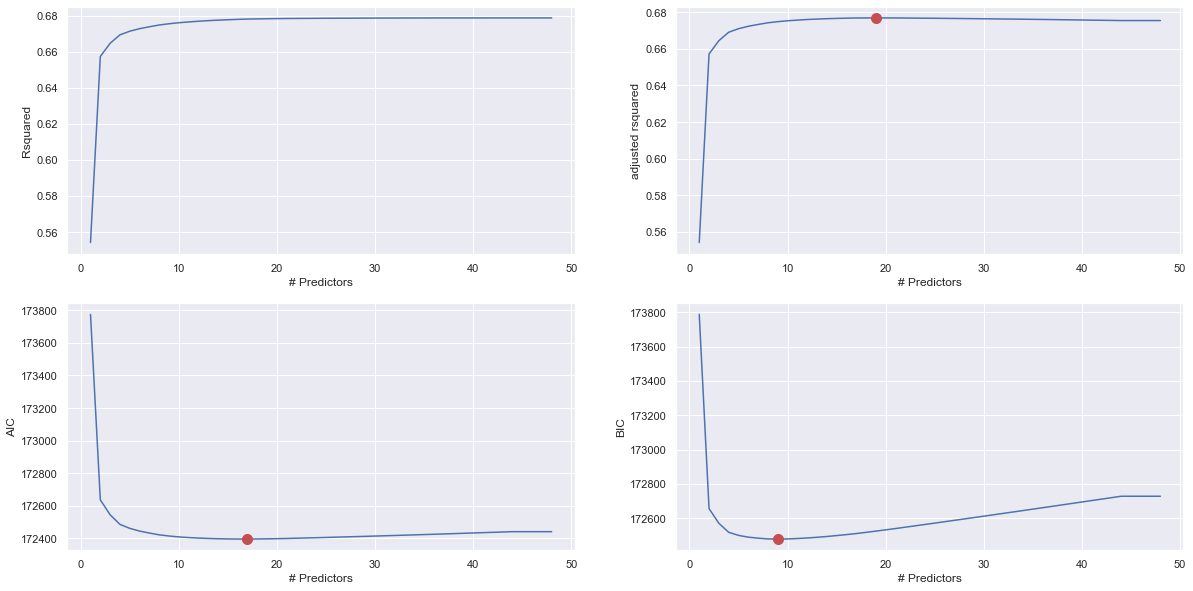

In [198]:
best_sub_plots()

In [199]:
best_bwd_reg_model6 = models_best['model'][9]
best_bwd_reg_model6.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  gross   R-squared:                       0.676
Model:                            OLS   Adj. R-squared:                  0.675
Method:                 Least Squares   F-statistic:                     999.9
Date:                Sun, 12 Mar 2023   Prob (F-statistic):               0.00
Time:                        04:51:40   Log-Likelihood:                -86197.
No. Observations:                4332   AIC:                         1.724e+05
Df Residuals:                    4322   BIC:                         1.725e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -2.662e+07   3.61e+06     -7.368      0.000   -3.37e+07   -1.95e+07
votes        380.9431     10.018     38.026      0.000     361.303     400.583
budget         2.4607      0.047     52.136      0.000       2.368       2.553
Europe     -1.393e+07    4.6e+06     -3.028      0.002   -2.29e+07   -4.91e+06
Comedy      1.316e+07   3.79e+06      3.475      0.001    5.73e+06    2.06e+07
Horror      3.737e+07   7.86e+06      4.758      0.000     2.2e+07    5.28e+07
Animation   7.267e+07   7.71e+06      9.428      0.000    5.76e+07    8.78e+07
Family       4.84e+08   6.13e+07      7.890      0.000    3.64e+08    6.04e+08
R            -1.7e+07   3.49e+06     -4.876      0.000   -2.38e+07   -1.02e+07
October    -1.963e+07   5.49e+06     -3.579      0.000   -3.04e+07   -8.88e+06
==============================================================================
Omnibus:                     3391.792   Durbin-Watson:                   2.022
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           248530.926
Skew:                           3.164   Prob(JB):                         0.00
Kurtosis:                      39.563   Cond. No.                     2.09e+09
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.09e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [200]:
best_bwd_reg_model7 = models_best['model'][18]
best_bwd_reg_model7.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  gross   R-squared:                       0.678
Model:                            OLS   Adj. R-squared:                  0.677
Method:                 Least Squares   F-statistic:                     505.1
Date:                Sun, 12 Mar 2023   Prob (F-statistic):               0.00
Time:                        04:52:00   Log-Likelihood:                -86179.
No. Observations:                4332   AIC:                         1.724e+05
Df Residuals:                    4313   BIC:                         1.725e+05
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -7.633e+08   3.36e+08     -2.272      0.023   -1.42e+09   -1.05e+08
year         3.45e+05   1.68e+05      2.059      0.040    1.65e+04    6.73e+05
score       6.507e+06   2.05e+06      3.173      0.002    2.49e+06    1.05e+07
votes        360.4720     11.656     30.925      0.000     337.619     383.325
budget         2.4423      0.050     48.704      0.000       2.344       2.541
Europe     -1.512e+07   4.62e+06     -3.269      0.001   -2.42e+07   -6.05e+06
Comedy      1.224e+07   3.86e+06      3.173      0.002    4.68e+06    1.98e+07
Biography  -1.106e+07    7.3e+06     -1.514      0.130   -2.54e+07    3.26e+06
Horror      4.108e+07   7.97e+06      5.157      0.000    2.55e+07    5.67e+07
Animation   6.412e+07   8.03e+06      7.980      0.000    4.84e+07    7.99e+07
Family      4.737e+08   6.13e+07      7.728      0.000    3.54e+08    5.94e+08
R          -1.482e+07   3.79e+06     -3.911      0.000   -2.22e+07   -7.39e+06
PG          1.202e+07   5.04e+06      2.385      0.017    2.14e+06    2.19e+07
June        1.105e+07   6.25e+06      1.768      0.077    -1.2e+06    2.33e+07
July         1.69e+07   6.12e+06      2.764      0.006    4.91e+06    2.89e+07
May         1.996e+07   6.37e+06      3.132      0.002    7.47e+06    3.25e+07
December    7.262e+06   6.16e+06      1.179      0.239   -4.82e+06    1.93e+07
October    -1.441e+07   5.66e+06     -2.546      0.011   -2.55e+07   -3.31e+06
April       1.315e+07   6.19e+06      2.124      0.034    1.01e+06    2.53e+07
==============================================================================
Omnibus:                     3429.752   Durbin-Watson:                   2.025
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           253628.001
Skew:                           3.220   Prob(JB):                         0.00
Kurtosis:                      39.928   Cond. No.                     1.15e+10
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.15e+10. This might indicate that there are
strong multicollinearity or other numerical problems.
"""